# A/B tests с Python




<a id="Libraries"></a>
##  Загрузка библиотек

In [ ]:
from scipy.stats import ttest_1samp
import numpy as np

import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


## Урок 8. Python применение статистических критериев на практике - пайплайн оценки A/B

На сайте запущен А/В тест с целью увеличить доход. В приложенном excel файле вы найдете сырые данные по результатам эксперимента – user_id, тип выборки variant_name и доход принесенный пользователем revenue.
Проанализируйте результаты эксперимента и напишите свои рекомендации менеджеру.



#Подготовка данных

In [ ]:
#Подгружаем данные с гугл диска
from google.colab import drive
drive.mount('/content/drive')


data = pd.read_excel('/content/drive/MyDrive/AB_Test_Results.xlsx')

data.head(10)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0
5,2380,variant,0.0
6,2849,control,0.0
7,9168,control,0.0
8,6205,variant,0.0
9,7548,control,0.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [ ]:
data.shape

(10000, 3)

In [ ]:
data.describe()

,USER_ID,REVENUE
count,10000.000000,10000.000000
mean,4981.080200,0.099447
std,2890.590115,2.318529
min,2.000000,0.000000
25%,2468.750000,0.000000
50%,4962.000000,0.000000
75%,7511.500000,0.000000
max,10000.000000,196.010000


In [ ]:
data.isna().sum()

USER_ID         0
VARIANT_NAME    0
REVENUE         0
dtype: int64

In [ ]:
data.VARIANT_NAME.value_counts()

variant    5016
control    4984
Name: VARIANT_NAME, dtype: int64

In [ ]:
data.USER_ID.nunique()

6324

In [ ]:
#Избавимся от некорретных строк. Посчитаем, сколько типов встречается у каждого пользователя.

v = data.groupby('USER_ID', as_index=False).agg({'VARIANT_NAME': pd.Series.nunique})
v

,USER_ID,VARIANT_NAME
0,2,1
1,3,2
2,4,1
3,5,1
4,6,1
...,...,...
6319,9993,1
6320,9995,1
6321,9996,2
6322,9998,1


In [ ]:
more_than_one_types = v.query('VARIANT_NAME > 1')
more_than_one_types

,USER_ID,VARIANT_NAME
1,3,2
6,10,2
11,18,2
15,25,2
23,40,2
...,...,...
6310,9978,2
6311,9979,2
6313,9982,2
6321,9996,2


In [ ]:
df_new = data[~data.USER_ID.isin(more_than_one_types.USER_ID)].sort_values('USER_ID')
df_new

,USER_ID,VARIANT_NAME,REVENUE
3479,2,control,0.0
7076,2,control,0.0
2406,2,control,0.0
9077,4,variant,0.0
9155,5,variant,0.0
...,...,...,...
3260,9992,control,0.0
9290,9993,control,0.0
2749,9995,variant,0.0
5673,9995,variant,0.0


In [ ]:
data.shape

(10000, 3)

In [ ]:
control = df_new.query('VARIANT_NAME == "control"')

test = df_new.query('VARIANT_NAME == "variant"')

In [ ]:
len(control)

3026

In [ ]:
len(test)

3044

In [ ]:
renenue_plus = data[data['REVENUE']>0]
renenue_plus

,USER_ID,VARIANT_NAME,REVENUE
13,2529,variant,2.15
49,6429,control,3.25
139,3331,variant,4.27
149,8110,variant,1.75
152,8607,control,2.99
...,...,...,...
9651,9928,variant,1.25
9711,6468,control,2.93
9724,5205,control,14.17
9725,702,variant,2.92


In [ ]:
renenue_plus_v = renenue_plus.groupby('USER_ID', as_index=False).agg({'VARIANT_NAME': pd.Series.nunique})
renenue_plus_v

,USER_ID,VARIANT_NAME
0,56,1
1,124,1
2,169,1
3,282,1
4,403,1
...,...,...
145,9669,1
146,9766,1
147,9928,1
148,9942,1


Посмотрим на группы отдельно

In [ ]:
data[data['VARIANT_NAME']=='control'].describe()

,USER_ID,REVENUE
count,4984.000000,4984.000000
mean,4989.436798,0.129013
std,2905.145109,3.007524
min,2.000000,0.000000
25%,2466.000000,0.000000
50%,4964.500000,0.000000
75%,7576.250000,0.000000
max,10000.000000,196.010000


In [ ]:
data[data['VARIANT_NAME']=='variant'].describe()

,USER_ID,REVENUE
count,5016.000000,5016.000000
mean,4972.776914,0.070070
std,2876.320625,1.314802
min,3.000000,0.000000
25%,2476.500000,0.000000
50%,4958.500000,0.000000
75%,7415.250000,0.000000
max,10000.000000,58.630000


Пока ничего необычного

In [ ]:
from scipy.stats import *

Применяем Шапиро уилка из-за того что менее 5000 наблюдений

In [ ]:
alpha = 0.05

st = shapiro(data.REVENUE)
print('Distribution is {}normal\n'.format( {True:'not ',\
                                            False:''}[st[1] < alpha]));

Distribution is not normal



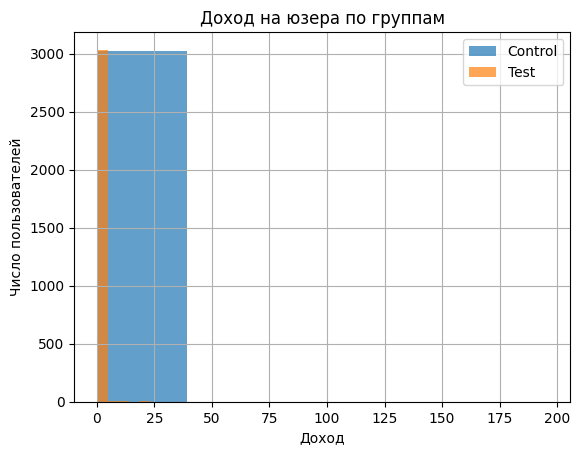

In [ ]:
control.REVENUE.hist(bins = 5, alpha =0.7, label='Control')
test.REVENUE.hist(bins = 5, alpha =0.7, label='Test')
plt.title('Доход на юзера по группам')
plt.xlabel('Доход')
plt.ylabel('Число пользователей')
plt.legend();

In [ ]:
mw_stats = mannwhitneyu(x=control.REVENUE.values,
                        y=test.REVENUE.values)
mw_stats

MannwhitneyuResult(statistic=4622832.0, pvalue=0.2444173738649208)

т.к.p-value > 5% то статистической значимости нет.

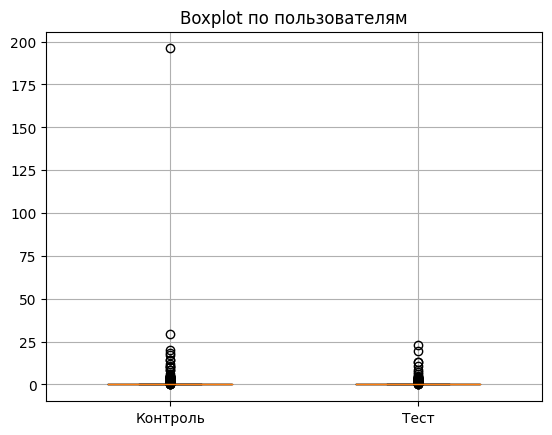

In [ ]:
plt.boxplot([control.REVENUE,test.REVENUE],
            labels=['Контроль','Тест'],
            widths=0.5
           )
plt.title('Boxplot по пользователям',  loc='center')
plt.grid(axis  ='both')

In [ ]:
stats.ttest_ind(control.REVENUE.values, test.REVENUE.values, equal_var = False)

Ttest_indResult(statistic=1.403762252371675, pvalue=0.1604844017690842)

Мы не можем отвергнуть нулевую гипотезу в пользу альтернативной
и у нас не достаточно данных, статистической значимой разницы нет.

##Расчет мощности


d = (M1 – M2) / S_pooled






## S_pooled =

  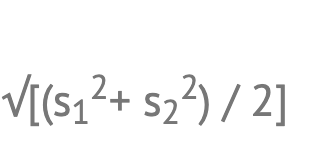

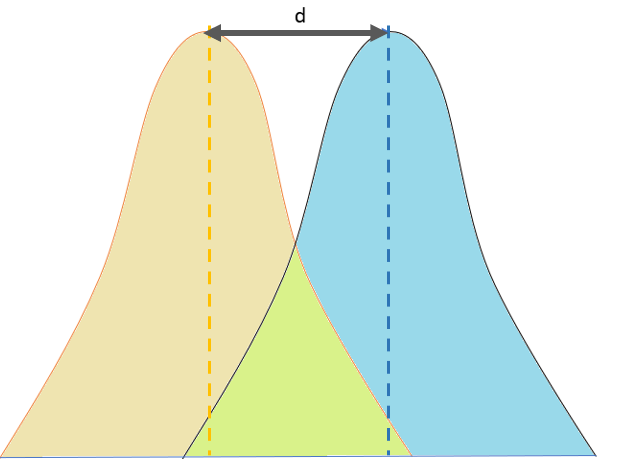

In [ ]:
C_mean = control.REVENUE.values.mean()

T_mean = test.REVENUE.values.mean()


C_std = control.REVENUE.values.std()

T_std = test.REVENUE.values.std()

In [ ]:
print(len(control.REVENUE.values), len(test.REVENUE.values))

3026 3044


In [ ]:
n =  len(control.REVENUE.values)
n

3026

In [ ]:
##S = np.sqrt((sd_t**2 / n_t) + (sd_c**2 / n_c)) - это если группы не равные

S_pooled = np.sqrt((T_std**2 + C_std**2)/ 2)
S_pooled

2.6764947104039547

In [ ]:
ef =float((T_mean-C_mean)/ S_pooled)
ef

-0.0360905955737073

In [ ]:
# parameters for power analysis
from statsmodels.stats.power import TTestIndPower
alpha = 0.05

# perform power analysis
analysis = TTestIndPower()
result = analysis.solve_power(ef, power=None, nobs1=n, ratio=1.0, alpha=alpha)

result

0.2893670730459212

Вывод: нет статистической значимой разницы по нашей одной из ключевой метрике, сам тест вызывет вопросы т.к. юзера поподали в обе группы. Вопросы к дизайну, запуску, может быть был не поставлен корректно.
Очень большая дисперсия в данных.
Оценили мощность к t критерию и она низкая всего 29%, должно быть около 80%
рекомендации перезапустить тест, определить длительность, задизайнить длительность.